Скрипт для расчета бизнес-метрик (CRR, CR, ACL, RPR, AOV, PF, CV).

In [1]:
import numpy as np
import pandas as pd

Метрики:
1. ***Customer Retention Rate (CRR)*** = (total clients on end period - total new clients for period) / total clients on first period 
2. ***Churn Rate (CR)*** = total clients lost / total clients on first period 
3. ***Average Customer Lifetime (ACL)*** = 1 / churn rate
4. ***Customer Value (CV)*** 

Average Order Value (AOV) = total revenue / number of orders   
Purchase Frequency (PF) = total orders / unique customers  
Customer Value (CV) = AOV * PF
5. ***Repeat Purchase Rate (RPR)***

Repeat Purchase Rate (RPR) = number of customers who bought more than once for period / total number of customers for period
6. Так же, для информативности, выведем в реальном выражении значения количества покупателей:  
**'Количество клиентов на начало периода' (clients_period_start)**,  
**'Количество клиентов на конец периода' (clients_period_end)**,  
**'Количество новых клиентов' (clients_new)**,  
**'Пересечение клиентов в конце и начале периода' (clients_intersect)**,  
**'Количество ушедших клиентов' (clients_lost)**.  

Сделаем расчеты бизнес-метрик:

In [48]:
# CRR, CR, ACL (месяц к месяцу): 

# функция всё посчитает и запишет в словарь

# сustomer retention rate (CRR) = (total clients on end period - total new clients for period) / total clients on first period
# churn rate (CR) = total clients lost / total clients on first period
# average customer lifetime (ACL) = 1 / churn rate 

mertics_dict = {}

def crr_cr_acl(df):

    for i in range(1, len(df['Month'].unique())):
        total_clients_on_first = df[df['Month'] == i]['customer_id'].unique()
        total_clients_on_end = df[df['Month'] == i+1]['customer_id'].unique()
        total_clients_on_first_count = df[df['Month'] == i]['customer_id'].nunique()
        total_clients_on_end_count = df[df['Month'] == i+1]['customer_id'].nunique()
        intersection = len(set(total_clients_on_end).intersection(total_clients_on_first))
        count_new_clients = total_clients_on_end_count - intersection
        total_clients_lost = total_clients_on_first_count - intersection
    
        crr = round(((total_clients_on_end_count - count_new_clients) / total_clients_on_first_count) * 100, 2)
        cr = round(total_clients_lost / total_clients_on_first_count * 100, 2)
        acl = round(1 / cr * 100, 2)
        
        mertics_dict[i+1] = [total_clients_on_first_count, total_clients_on_end_count, count_new_clients, intersection, total_clients_lost, crr, cr, acl]

crr_cr_acl(df)

In [51]:
# RPR, AOV, PF, CV (за месяц): 

# функция всё посчитает и запишет в словарь

# repeat purchase rate (RPR) = number of customers who bought more than once for period / total number of customers for period
# average order value (AOV) = total revenue / number of orders
# purchase frequency (PF) = total orders / unique customers
# customer value (CV) = aov * pf

def delivery_count_calc(df):
                
    df['order_deliv_count'] = 0
    delivered_count = df.groupby(['customer_id'])['order_id'].nunique()
    for i in delivered_count.unique():
        index = delivered_count[delivered_count == i].index
        df['order_deliv_count'].at[df['customer_id'].isin(index)] = i

def rpr_aov_pf_cv(df):
    for i in df['Month'].unique():
        rpr = round((df[(df['order_deliv_count'] >= 2) & (df['Month'] == i)]['order_id'].nunique() / 
                df[(df['order_deliv_count'] >= 1) & (df['Month'] == i)]['order_id'].nunique()) * 100, 2)
        mertics_dict[i].append(rpr)
        aov = round(df[df['Month'] == i].groupby(['customer_id'])['order_sum'].sum() / 
                    df[df['Month'] == i].groupby(['customer_id'])['order_id'].nunique(), 2)
        mertics_dict[i].append(round(aov.mean(), 2))
        pf = round(df[df['Month'] == i]['order_id'].nunique() / 
                   df[df['Month'] == i]['customer_id'].drop_duplicates().nunique(), 2)
        mertics_dict[i].append(pf)
        cv = round(aov.mean() * pf, 2)
        mertics_dict[i].append(cv)
        #print('Месяц:', i, 'RPR:', rpr, 'AOV:', round(aov.mean(), 2), 'PF:', pf, 'CV:', cv)
        
delivery_count_calc(df)
rpr_aov_pf_cv(df)

C:\Users\anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\anaconda\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\anaconda\Anaconda3\lib\site-packages\pandas\core\series.py:1142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [53]:
# сделаем из словаря, куда всё собрали, таблицу со всеми метриками
# 13 строка - за год в целом

metrix = pd.DataFrame.from_dict(mertics_dict, orient='index', columns=['clients_period_start', 'clients_period_end', 'clients_new', 'clients_intersect', 'clients_lost', 'CRR', 'CR', 'ACL', 'RPR', 'AOV', 'PF', 'CV'])
metrix.sort_index(inplace=True)
metrix

,clients_period_start,clients_period_end,clients_new,clients_intersect,clients_lost,CRR,CR,ACL,RPR,AOV,PF,CV
1,10098,15033,8965,1133,8965,11.22,88.78,1.13,58.29,4412.080000,1.11,4897.41
2,15033,16102,14293,1809,13224,12.03,87.97,1.14,60.18,4161.830000,1.12,4661.25
3,16102,17905,15688,2217,13885,13.77,86.23,1.16,62.91,4229.660000,1.17,4948.71
4,17905,18521,16190,2331,15574,13.02,86.98,1.15,61.86,4017.890000,1.15,4620.57
5,18521,20178,17423,2755,15766,14.88,85.12,1.17,64.76,3811.290000,1.17,4459.21
6,20178,22472,19390,3082,17096,15.27,84.73,1.18,58.82,3998.770000,1.12,4478.62
7,22472,22775,19824,2951,19521,13.13,86.87,1.15,59.47,3880.860000,1.13,4385.37
8,22775,25120,21742,3378,19397,14.83,85.17,1.17,59.97,4010.290000,1.13,4531.63
9,25120,24884,21139,3745,21375,14.91,85.09,1.18,59.74,3982.560000,1.12,4460.46
10,24884,30313,26157,4156,20728,16.70,83.30,1.20,60.10,3900.430000,1.16,4524.50


In [54]:
# заодно выведем среднемесячные показатели за год:

metrix.iloc[:12, 5:].mean().to_frame().T

,CRR,CR,ACL,RPR,AOV,PF,CV
0,14.474167,85.525833,1.17,59.644167,4047.551667,1.138333,4606.315


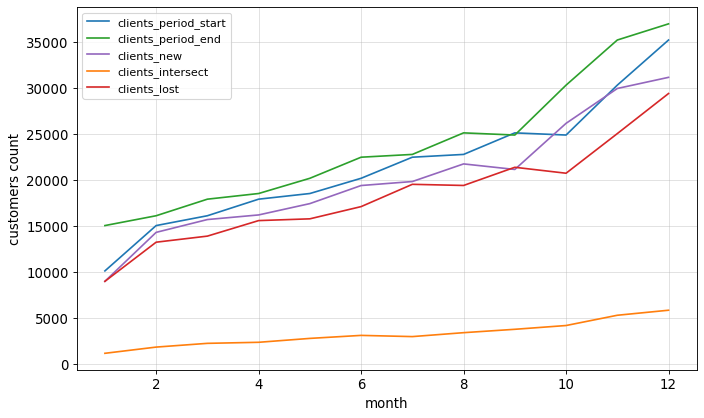

In [55]:
# нарисуем график, куда выведем изменение количества покупателей, по месяцам

x = metrix.index[:12]
y1 = metrix['clients_period_start'][:12]
y2 = metrix['clients_period_end'][:12]
y3 = metrix['clients_new'][:12]
y4 = metrix['clients_intersect'][:12]
y5 = metrix['clients_lost'][:12]

fig, ax1 = plt.subplots(1, 1, figsize = (10, 6), dpi = 80)
ax1.plot(x, y1, color='tab:blue', label='clients_period_start')
ax1.plot(x, y2, color='tab:green', label='clients_period_end')
ax1.plot(x, y3, color='tab:purple', label='clients_new')
ax1.plot(x, y4, color='tab:orange', label='clients_intersect')
ax1.plot(x, y5, color='tab:red', label='clients_lost')
ax1.legend(loc='upper left')

ax1.set_xlabel('month', fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('customers count', fontsize=12)
ax1.tick_params(axis='y', rotation=0, labelsize=12)
ax1.grid(alpha=.4)

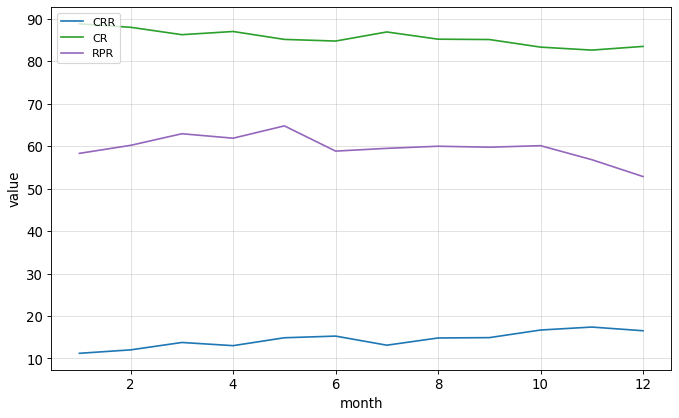

In [56]:
# теперь посмотрим на CRR, CR и RPR, по месяцам 

x = metrix.index[:12]
y1 = metrix['CRR'][:12]
y2 = metrix['CR'][:12]
y3 = metrix['RPR'][:12]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6), dpi= 80)
ax1.plot(x, y1, color='tab:blue', label='CRR')
ax1.plot(x, y2, color='tab:green', label='CR')
ax1.plot(x, y3, color='tab:purple', label='RPR')

ax1.legend(loc='upper left')

ax1.set_xlabel('month', fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('value', fontsize=12)
ax1.tick_params(axis='y', rotation=0, labelsize=12)
ax1.grid(alpha=.4)

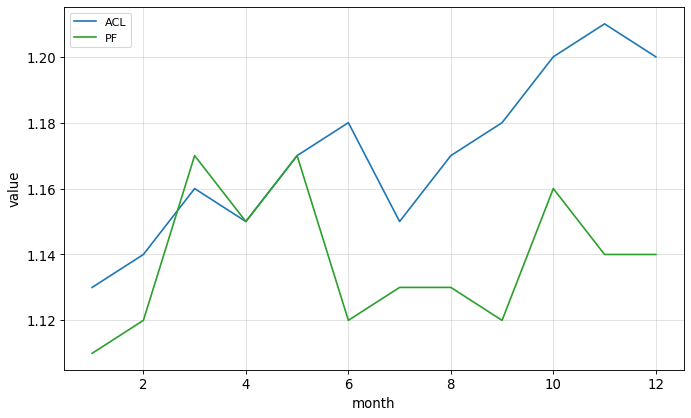

In [57]:
# теперь посмотрим на ACL и PF, по месяцам

x = metrix.index[:12]
y1 = metrix['ACL'][:12]
y2 = metrix['PF'][:12]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6), dpi= 80)
ax1.plot(x, y1, color='tab:blue', label='ACL')
ax1.plot(x, y2, color='tab:green', label='PF')

ax1.legend(loc='upper left')

ax1.set_xlabel('month', fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('value', fontsize=12)
ax1.tick_params(axis='y', rotation=0, labelsize=12)
ax1.grid(alpha=.4)

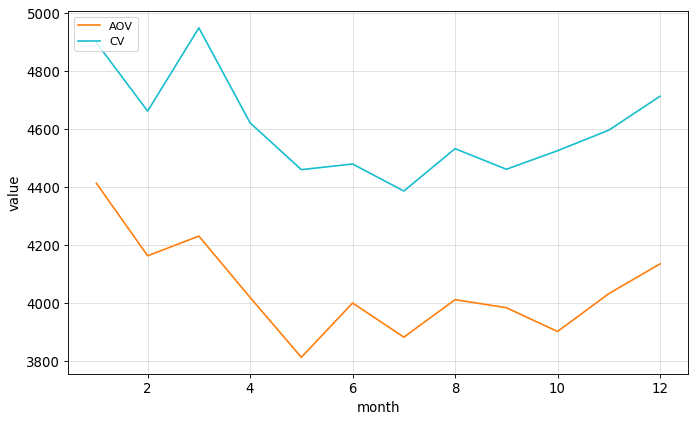

In [58]:
# теперь посмотрим на AOV и CV, по месяцам

x = metrix.index[:12]
y1 = metrix['AOV'][:12]
y2 = metrix['CV'][:12]

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6), dpi= 80)
ax1.plot(x, y1, color='tab:orange', label='AOV')
ax1.plot(x, y2, color='tab:cyan', label='CV')
ax1.legend(loc='upper left')

ax1.set_xlabel('month', fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)
ax1.set_ylabel('value', fontsize=12)
ax1.tick_params(axis='y', rotation=0, labelsize=12)
ax1.grid(alpha=.4) 